In [ ]:
import numpy as np

N = int(10**3 / 2.5)

np.random.seed(999)

u = np.random.choice([0,1], size=N)

thstar = [0,0.5]
theta = np.random.multivariate_normal([1,1], [[10, 0],[0, 2]], size=N)

# gen b
b = ( (1-u).reshape(-1,1) * np.random.multivariate_normal([800,1.8], [[200**2, 0],[0, 0.5]], size=N)
      +
      u.reshape(-1,1) * np.random.multivariate_normal([1000,2.2], [[200**2, 0],[0, 0.5]], size=N))

b[:,0] = np.clip(b[:,0], 400,1600)
b[:,1] = np.clip(b[:,1], 0,4)

# gen ε
e = np.array([10,1])

# gen o
o = ( (1-u) * np.random.normal(loc=0.5,scale=0.2,size=N)
      +
      u * np.random.normal(loc=1.5,scale=0.2,size=N))

# Simulate Q_plug

In [ ]:
base = b@thstar + o
improvement = (e*e*theta)@thstar

A = np.array([1,2]) # the bias of base performance
B = base.mean()     # E[bθ*+O]

sim_base = (A*theta).sum(axis=1) + B  # the simulated base performance

thao = A + (e*e*thstar)
thao /= np.linalg.norm(thao)

Q = A@thao + B + (e*e*thao)@thstar

In [ ]:
from tqdm import tqdm

observed_bases = []

#
# generating data
#
for th in tqdm(theta): # for each round?
  # the generating process
  th = np.tile(th, reps=(N,1))

  improvements = (e*e*th)@thstar
  biased_bases = (A*th).sum(axis=1) + B + np.random.normal(loc=0, scale=2) # measurement noise of individuals

  selected_y = biased_bases + improvements

  # the estimation
  observed_base = selected_y.mean() - improvements.mean()
  observed_bases.append(observed_base)

# post-processing
observed_bases = np.array(observed_bases)

100%|██████████| 400/400 [00:00<00:00, 6499.19it/s]


In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance

#
# estimate the bias coeff A, and then theta^AO
#

# assumed correct estimates of θ* & ε
thstar_hat = thstar #  θ*
eet_hat = e*e


diff_1 = []
diff_2 = []

cos_1 = []
cos_2 = []

Q_estimates = []
Q_plugs = []

diff_3 = []

idcs = range(10, N, 10)

# generate estimates of θ^AO
for idx in tqdm(idcs):
  reg = LinearRegression()
  reg.fit(X=theta[:idx],y=observed_bases[:idx])

  A_hat = reg.coef_
  thao_hat = A_hat + eet_hat*thstar_hat
  thao_hat /= np.linalg.norm(thao_hat)

  diff_A = np.linalg.norm(A_hat-A)
  diff_thao = np.linalg.norm(thao_hat-thao)

  diff_1.append(diff_A)
  diff_2.append(diff_thao)

  # cosine distance
  cos_A = distance.cosine(A_hat, A)
  cos_thao = distance.cosine(thao_hat, thao)

  cos_1.append(cos_A)
  cos_2.append(cos_thao)

  # objective function
  B_hat = reg.intercept_
  Q_hat = A_hat@thao_hat + B_hat + (eet_hat*thao_hat)@thstar_hat  # hat{Q}
  Q_plug = A@thao_hat + B + (e*e*thao_hat)@thstar                 # Q(hat{θ}^AO)

  diff_Q = np.linalg.norm(Q_plug-Q)

  Q_estimates.append(Q_hat)
  Q_plugs.append(Q_plug)
  
  diff_3.append(diff_Q)

100%|██████████| 39/39 [00:00<00:00, 346.35it/s]


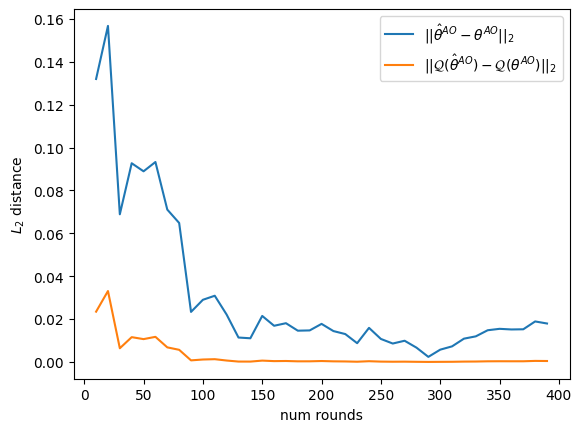

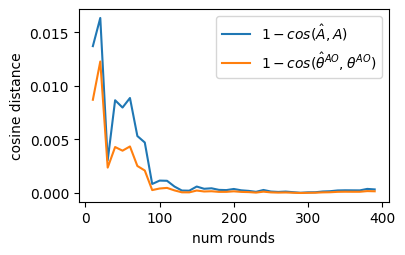

In [ ]:
import matplotlib.pyplot as plt

# plt.plot(idcs, diff_1, label=r'$||\hat{A}-A||_2$')
plt.plot(idcs, diff_2, label=r'$||\hat{\theta}^{AO}-\theta^{AO}||_2$')
plt.plot(idcs, diff_3, label=r'$||\mathcal{Q}(\hat{\theta}^{AO})-\mathcal{Q}(\theta^{AO})||_2$')
plt.xlabel('num rounds')
plt.ylabel(r'$L_2$ distance')
plt.legend()
plt.show()

zoom = 0
plt.figure(figsize=(4,2.5))
plt.plot(idcs[zoom:], cos_1[zoom:], label=r'$1-cos(\hat{A}, A)$')
plt.plot(idcs[zoom:], cos_2[zoom:], label=r'$1-cos(\hat{\theta}^{AO}, \theta^{AO})$')
plt.xlabel('num rounds')
plt.ylabel(r'cosine distance')
plt.legend()
plt.show()

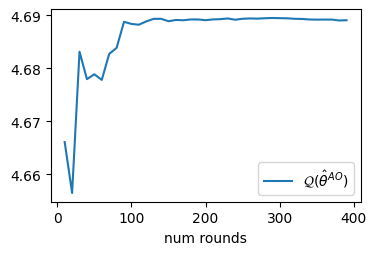

In [ ]:
plt.figure(figsize=(4,2.5))
plt.plot(idcs, Q_plugs, label=r'$\mathcal{Q}(\hat{\theta}^{AO})$')
plt.xlabel('num rounds')
plt.legend()
plt.show()